<a href="http://www.sundagas.com/">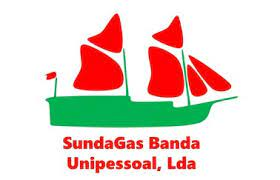 

<h1 align=center><font size = 5>Core Analysis - Chuditch 1 </font></h1>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P6059_Chuditch_CPR </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\CoreData_Chuditch'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [ ]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [ ]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [ ]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [ ]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )

    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [ ]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends 
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [ ]:
def plot_PP(mod_df, df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K_air (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0,45)
    plt.ylim(0.001,10000)

    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] # x-value
    y2 = df_sub["K_air (mD)"] #y-value
    
    # For fitting y = Ae^(Bx), log y = log A + Bx. So fit (log y) against x.
    #p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    #p = np.polyfit(y1, np.log(y2), 1)
    #f = np.poly1d(p)

    #ax.semilogy(y1, np.exp(p[0] * y1 + p[1]), 'k--', linewidth = 2.5)
    ax.set_yscale('log')

    #Display Equation
    #plt.text(16, 10, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
    #plt.title (title, fontsize = size)

    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return

##### Read in the data and some preprocessing

In [ ]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_Suriname.xlsx', 
    header=[0, 1], 
    sheet_name='MASTER', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_air (mD)', 'Porosity (%)', 'Grain Density (g/cc)', 'Core Type']
df.ends(10)

##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [ ]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_air (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_air (mD)'] > 0.01]
mod_df

###### Mapping each well to a colour

In [ ]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

In [ ]:
for well in mod_df['Well Name'].unique():
        print(mod_df[mod_df['Well Name'] == well].info())      
        print(mod_df[mod_df['Well Name'] == well].describe(include='all'))       

In [ ]:
print(mod_df.info())
print(mod_df.describe(include='all'))

## Determine Properties based on a particular Net Overburden Pressure (NOBP) value

In [ ]:
a = mod_df['NOB (psi)'].unique()
print(sorted(a))

Some of the net overburden values are missing. It will be assumed that these are ambient values i.e. 800 psi

In [ ]:
mod_df['NOB (psi)'].fillna(14.7, inplace=True)
mod_df['NOB (psi)'].isnull().values.any()

In [ ]:
NOBP = 800

df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

In [ ]:
savefn = "Hist_GD_800.png"

# fuction to plot - usage
# plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)

plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Ambient)", 100, 2, 3, savefn)

In [ ]:
savefn = "Hist_Poro_800.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (Ambient)", 20, 0, 35, savefn)

In [ ]:
savefn = "Hist_Perm_800.png"

x= df_sub["K_air (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K_air (mD)"], "Permeability (mD) (Ambient)", logbins, 0.01, x.max()+1000, savefn)
plt.xscale('log')

#### Plot cross-plot of Porosity-Permeability

In [ ]:
savefn = "Poro_Perm_800.png"

#Cutoff intercept
yint1 = 1
xint1 = 14

yint2 = 0.1
xint2 = 11

plot_PP(mod_df, df_sub, grouped, color, "Ambient Porosity vs Permeability", savefn, xint1, yint1, xint2, yint2)

##### Cross-plot for values not at NOBP of 800 psi

In [ ]:
# df_sub = mod_df[mod_df['NOB (psi)'] > NOBP]
# grouped = df_sub.groupby("Well Name")
# color = df_sub['color']

In [ ]:
# savefn = "Hist_GD_not_800.png"

# # fuction to plot - usage
# # plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)

# plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (>800 psi)", 20, 2.6, 2.8, savefn)

In [ ]:
# savefn = "Hist_Poro_not_800.png"
# plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (>800 psi)", 20, 0, 30, savefn)

In [ ]:
# savefn = "Hist_Perm_not_800.png"
# plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD) (>800 psi)", 100, 0, 50, savefn)

In [ ]:
# savefn = "Poro_Perm_not_800.png"

# #Cutoff intercept
# yint1 = 1
# xint1 = 6.498/0.5204

# yint2 = 0.1
# xint2 = (np.log(0.1)+6.498)/0.5204

# plot_PP(mod_df, df_sub, grouped, color, "Overburden Porosity vs Permeability", savefn, xint1, yint1, xint2, yint2)